In [1]:
import gc

import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import transformers
from sklearn.metrics import hamming_loss, jaccard_score, label_ranking_average_precision_score, f1_score
from matplotlib import pyplot as plt

In [2]:

random_seed = 0

MAX_LEN = 200 #based on length of tweets
BATCH_SIZE = 1
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
class BERT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.layer2 = torch.nn.Dropout(0.2)
        self.layer3 = torch.nn.Linear(768, 11)

    def forward(self, ids, mask, token_type_ids, return_dict = False):
        unw, out_1 = self.layer1(ids, attention_mask = mask, token_type_ids = token_type_ids)[0], self.layer1(ids, attention_mask = mask, token_type_ids = token_type_ids)[1]
        out_2 = self.layer2(out_1)
        out_final = self.layer3(out_2)
        return out_final

model = BERT()
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT(
  (layer1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
     

In [4]:
data = twitter_data = pd.read_csv('Data/data_set.csv', sep='|')

In [5]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.dataframe = dataframe
        self.text = dataframe['Text']
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens = True,
            max_length = self.max_len,
            padding='max_length',
            return_token_type_ids = True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']

        return {
            'ids' : torch.tensor(ids, dtype = torch.long),
            'mask' : torch.tensor(mask, dtype = torch.long),
            'token_type_ids' : torch.tensor(token_type_ids, dtype = torch.long),
            'text' : text
        }

In [6]:
data_set = CustomDataset(data, tokenizer, MAX_LEN)

In [7]:
data_loader = DataLoader(data_set, shuffle = False, batch_size = BATCH_SIZE)

In [8]:
# load bin model parameters
model.load_state_dict(torch.load('Model/bert_model_5.bin'))

<All keys matched successfully>

In [9]:
req_outputs = []
gc.collect()
torch.cuda.empty_cache()
texts = []
with torch.no_grad():
    for unw, data in enumerate(data_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        outputs = model(ids, mask, token_type_ids)
        req_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
        texts.extend(data['text'])

In [10]:
len(req_outputs)

1082

In [11]:
outputs = np.array(req_outputs)
outputs.shape

(1082, 11)

In [12]:
len(data_set)

1082

In [24]:
int_outputs = np.zeros((outputs.shape[0], outputs.shape[1]))

for row in range(outputs.shape[0]):
    for col in range(outputs.shape[1]):
        if outputs[row][col] >= 0.5: int_outputs[row][col] = 1

In [25]:
int_outputs

array([[1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [26]:
# add predictions to dataframe
sentiment_labels = ['Optimistic','Thankful','Empathetic','Pessimistic','Anxious','Sad','Annoyed','Denial','Official report','Surprise','Joking']
for i in range(len(sentiment_labels)):
    data_set.dataframe[sentiment_labels[i]] = int_outputs[:,i]

data_set.dataframe

,Text,Chapter,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Surprise,Joking
0,The Way that can be told of is not an Unvaryin...,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,The names that can be named are not unvarying ...,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,It was from the Nameless that Heaven and Earth...,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,The named is but the mother that rears the ten...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Truly, “Only he that rids himself forever of d...",1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,"Lo, he has more than before!",81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1078,When his own last scrap has been used up in gi...,81,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1079,"Lo, his stock is even greater than before!",81,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1080,"For heaven's way is to sharpen without cutting,",81,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# save dataframe with predictions
data_set.dataframe.to_csv('Data/data_set_with_predictions.csv', sep='|', index=False)


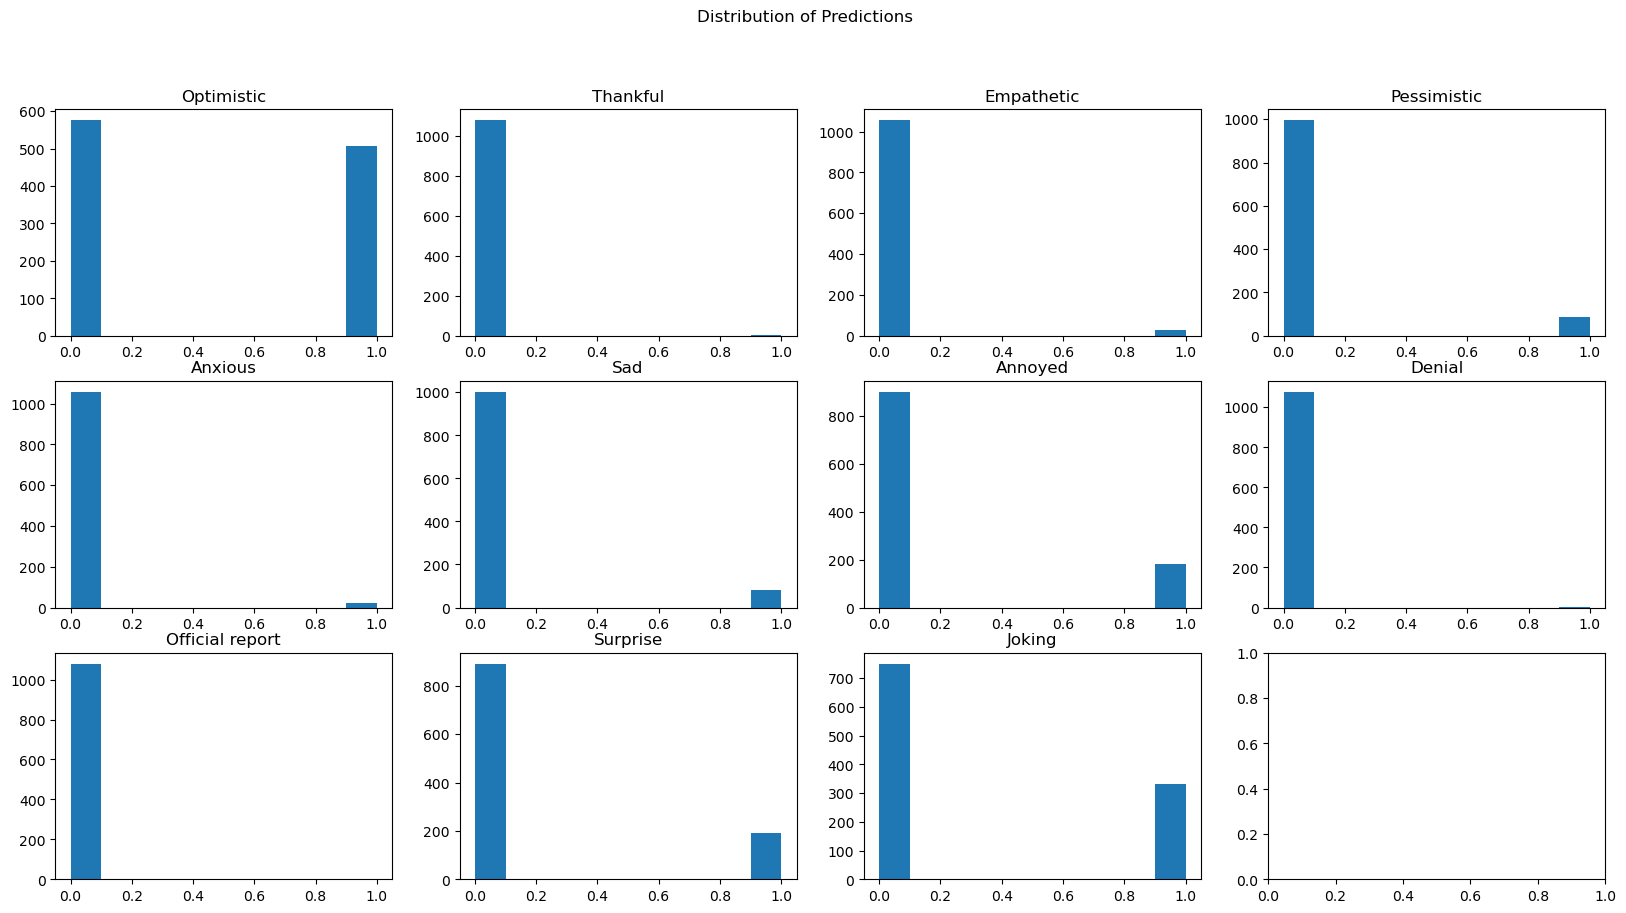

In [31]:
# distribution of predictions and visualise all in one plot
fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.suptitle('Distribution of Predictions')
for i in range(len(sentiment_labels)):
    axs[i//4, i%4].hist(data_set.dataframe[sentiment_labels[i]])
    axs[i//4, i%4].set_title(sentiment_labels[i])
plt.show()


In [36]:
# most sentiment labels per chapter and visualise all in one plot
chapter_group = data_set.dataframe.groupby('Chapter').sum()
chapter_group

/tmp/ipykernel_4988/217694493.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  chapter_group = data_set.dataframe.groupby('Chapter').sum()


,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Surprise,Joking
Chapter,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,5.0
2,14.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,4.0,9.0
3,12.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0,1.0
4,3.0,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,1.0,3.0
5,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...
77,4.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,6.0
78,6.0,0.0,1.0,2.0,0.0,1.0,2.0,0.0,1.0,2.0,3.0
79,6.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,3.0


In [ ]:
# sentiment label persentage per chapter
chapter_group = chapter_group.div(chapter_group.sum(axis=1), axis=0)
chapter_group